# Constructing simple models of biochemical networks

Tutorial based on the Python tutorials for BondGraphTools, which can be found here: https://github.com/mic-pan/BGT_BiochemicalNetworkTutorials

In [2]:
# Since BondGraphs is not yet in the package manager, we will need to include it directly from Github
# using Pkg; Pkg.add(url="https://github.com/jedforrest/BondGraphs.git")
push!(LOAD_PATH, "C:/Users/jedfo/.julia/dev/BondGraphs/src/")
using BondGraphs

In [3]:
using Plots
using ModelingToolkit
using Catalyst

## A simple biochemical example
$$
A + B \rightleftharpoons C
$$
BondGraphs can convert Catalyst reaction networks into a BondGraph

In [4]:
abc = @reaction_network ABC begin
    1, A + B --> C
end

Model ABC with 1 equations
States (3):
  A(t)
  B(t)
  C(t)
Parameters (0):

In [5]:
bg_abc = BondGraph(abc)

BondGraph ABC (5 Nodes, 4 Bonds)

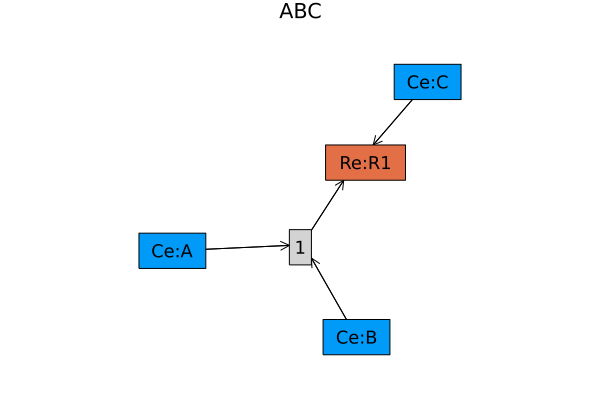

In [6]:
plot(bg_abc, fontsize=12)

In [7]:
re, one, A, B, C, = nodes(bg_abc)

5-element Vector{AbstractNode}:
 Re:R1
 𝟏_2
 Ce:A
 Ce:B
 Ce:C

In [8]:
constitutive_relations(A)

2-element Vector{Equation}:
 0 ~ R*T*log(K*q(t)) - E[1](t)
 Differential(t)(q(t)) ~ F[1](t)

In [9]:
constitutive_relations(re)

2-element Vector{Equation}:
 0 ~ F[1](t) + F[2](t)
 0 ~ F[1](t) - r*(exp(E[1](t) / (R*T)) - exp(E[2](t) / (R*T)))

In [10]:
eqs = constitutive_relations(bg_abc)

3-element Vector{Equation}:
 Differential(t)(A₊q(t)) ~ -R1₊r*(A₊K*B₊K*A₊q(t)*B₊q(t) - C₊K*C₊q(t))
 Differential(t)(B₊q(t)) ~ -R1₊r*(A₊K*B₊K*A₊q(t)*B₊q(t) - C₊K*C₊q(t))
 Differential(t)(C₊q(t)) ~ R1₊r*(A₊K*B₊K*A₊q(t)*B₊q(t) - C₊K*C₊q(t))

In [11]:
eqs = constitutive_relations(bg_abc; sub_defaults=true)

3-element Vector{Equation}:
 Differential(t)(A₊q(t)) ~ -(A₊q(t)*B₊q(t) - C₊q(t))
 Differential(t)(B₊q(t)) ~ -(A₊q(t)*B₊q(t) - C₊q(t))
 Differential(t)(C₊q(t)) ~ A₊q(t)*B₊q(t) - C₊q(t)

In [12]:
sys = ODESystem(bg_abc)
display("text/plain", sys)

Model ABC with 3 equations
States (3):
  A₊q(t) [defaults to 0.0]
  B₊q(t) [defaults to 0.0]
  C₊q(t) [defaults to 0.0]
Parameters (6):
  R1₊r [defaults to 1.0]
  T [defaults to 310.0]
  R [defaults to 8.314]
  A₊K [defaults to 1.0]
  B₊K [defaults to 1.0]
  C₊K [defaults to 1.0]
Incidence matrix:
 ×  ⋅  ⋅  ×  ×  ×
 ⋅  ×  ⋅  ×  ×  ×
 ⋅  ⋅  ×  ×  ×  ×

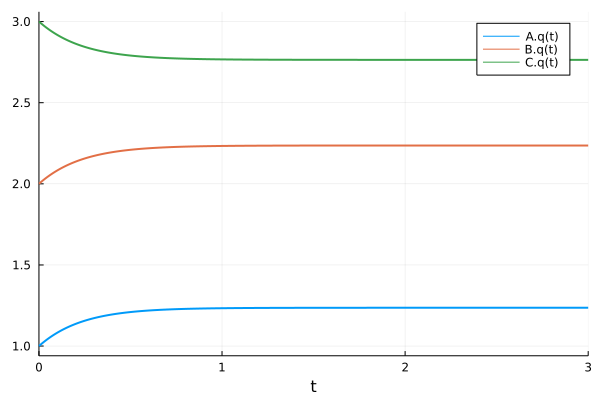

In [13]:
tspan = (0., 3.)
u0 = [1, 2, 3]
sol = simulate(bg_abc, tspan; u0)
plot(sol, lw=2)

## Stoichiometric Example
$$
A + 2B \rightleftharpoons 3C
$$

In [18]:
a2b2c = @reaction_network A2B2C begin
    1, A + 2B --> 3C
end

Model A2B2C with 1 equations
States (3):
  A(t)
  B(t)
  C(t)
Parameters (0):

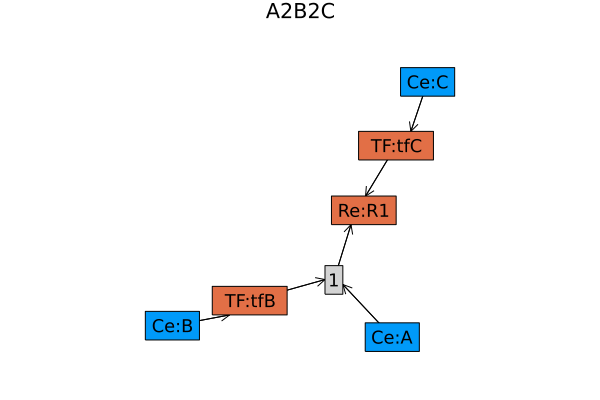

In [19]:
bg_a2b2c = BondGraph(a2b2c)
plot(bg_a2b2c, fontsize=12)

In [20]:
eqs = constitutive_relations(bg_a2b2c; sub_defaults=true)

3-element Vector{Equation}:
 Differential(t)(A₊q(t)) ~ -((B₊q(t)^2)*A₊q(t) - (C₊q(t)^3))
 Differential(t)(B₊q(t)) ~ -2.0((B₊q(t)^2)*A₊q(t) - (C₊q(t)^3))
 Differential(t)(C₊q(t)) ~ 3((B₊q(t)^2)*A₊q(t) - (C₊q(t)^3))

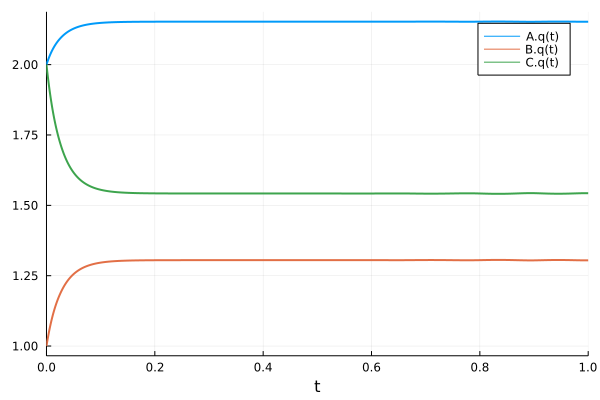

In [24]:
tspan = (0., 1.)
u0 = [2, 1, 2]
sol = simulate(bg_a2b2c, tspan; u0)
plot(sol, lw=2)

## The reversible Michaelis-Menten model
$$
E + S \rightleftharpoons C \\ 
C \rightleftharpoons E + P
$$

In [25]:
rn_mm = @reaction_network MM_reversible begin
    (1, 1), E + S <--> C
    (1, 1), C <--> E + P
end

Model MM_reversible with 4 equations
States (4):
  E(t)
  S(t)
  C(t)
  P(t)
Parameters (0):

Chemostats are chemical species that are held constant throught the reaction (`Se` in bond graph terms)

In [26]:
bg_mm = BondGraph(rn_mm; chemostats=["S", "P"])

BondGraph MM_reversible (10 Nodes, 10 Bonds)

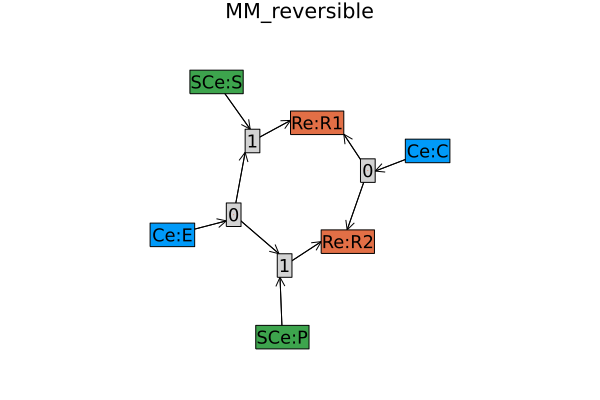

In [27]:
plot(bg_mm, fontsize=12)

In [28]:
# Update default concentration for the substrate
bg_mm.S.xs = t -> 2

#1 (generic function with 1 method)

In [29]:
constitutive_relations(bg_mm)

2-element Vector{Equation}:
 Differential(t)(E₊q(t)) ~ -(R1₊r*(2E₊K*S₊K*E₊q(t) - C₊K*C₊q(t)) - R2₊r*(C₊K*C₊q(t) - E₊K*P₊K*E₊q(t)))
 Differential(t)(C₊q(t)) ~ R1₊r*(2E₊K*S₊K*E₊q(t) - C₊K*C₊q(t)) - R2₊r*(C₊K*C₊q(t) - E₊K*P₊K*E₊q(t))

In [30]:
sys = ODESystem(bg_mm)
display("text/plain", sys)

Model MM_reversible with 2 equations
States (2):
  E₊q(t) [defaults to 0.0]
  C₊q(t) [defaults to 0.0]
Parameters (10):
  R1₊r [defaults to 1.0]
  T [defaults to 310.0]
  R [defaults to 8.314]
  E₊K [defaults to 1.0]
  S₊K [defaults to 1.0]
  S₊xs(t) [defaults to #1]
⋮
Incidence matrix:
 ×  ⋅  ×  ×
 ⋅  ×  ×  ×

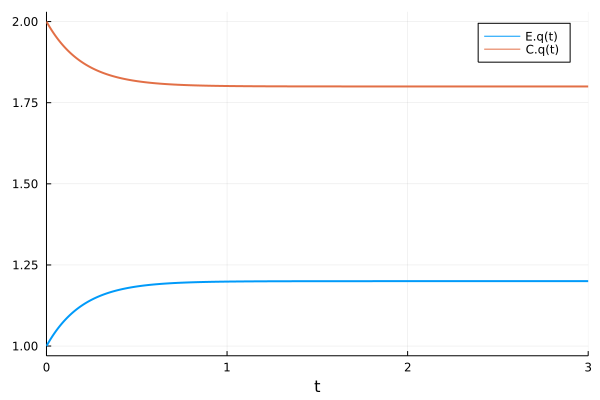

In [31]:
tspan = (0., 3.)
u0 = [1,2]
sol = simulate(bg_mm, tspan; u0)
plot(sol, lw=2)

In [32]:
# Rerun simulation with a substrate which increases over time
bg_mm.S.xs = t -> 1 + t
constitutive_relations(bg_mm)

2-element Vector{Equation}:
 Differential(t)(E₊q(t)) ~ -(R1₊r*(E₊K*S₊K*(1 + t)*E₊q(t) - C₊K*C₊q(t)) - R2₊r*(C₊K*C₊q(t) - E₊K*P₊K*E₊q(t)))
 Differential(t)(C₊q(t)) ~ R1₊r*(E₊K*S₊K*(1 + t)*E₊q(t) - C₊K*C₊q(t)) - R2₊r*(C₊K*C₊q(t) - E₊K*P₊K*E₊q(t))

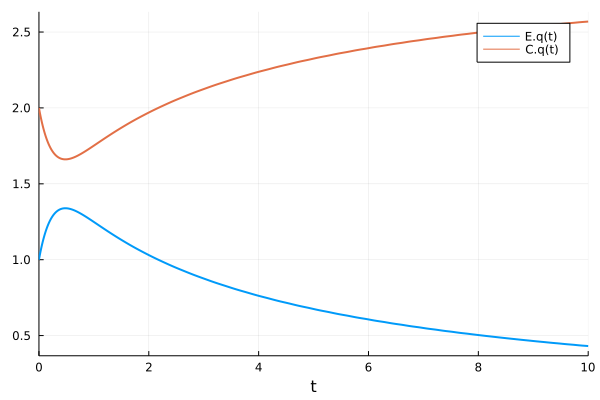

In [33]:
tspan = (0., 10.)
u0 = [1,2]
sol = simulate(bg_mm, tspan; u0)
plot(sol, lw=2)